In [1]:
import pandas as pd
import numpy as np
import random
import matplotlib.pyplot as plt
%matplotlib inline
random.seed(55)

In [2]:
df = pd.read_csv('ab_data.csv')
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 294478 entries, 0 to 294477
Data columns (total 5 columns):
 #   Column        Non-Null Count   Dtype 
---  ------        --------------   ----- 
 0   user_id       294478 non-null  int64 
 1   timestamp     294478 non-null  object
 2   group         294478 non-null  object
 3   landing_page  294478 non-null  object
 4   converted     294478 non-null  int64 
dtypes: int64(2), object(3)
memory usage: 11.2+ MB


In [3]:
df.head()

,user_id,timestamp,group,landing_page,converted
0,851104,2017-01-21 22:11:48.556739,control,old_page,0
1,804228,2017-01-12 08:01:45.159739,control,old_page,0
2,661590,2017-01-11 16:55:06.154213,treatment,new_page,0
3,853541,2017-01-08 18:28:03.143765,treatment,new_page,0
4,864975,2017-01-21 01:52:26.210827,control,old_page,1


In [4]:
df.groupby(['group','converted']).agg('count')

user_id  timestamp  landing_page
group     converted                                  
control   0           129479     129479        129479
          1            17723      17723         17723
treatment 0           129762     129762        129762
          1            17514      17514         17514

In [5]:
df.drop(df.query("group == 'control' and landing_page == 'new_page'").index, inplace=True)
df.drop(df.query("group == 'treatment' and landing_page == 'old_page'").index, inplace=True)

df.groupby(['group','converted']).agg('count')

user_id  timestamp  landing_page
group     converted                                  
control   0           127785     127785        127785
          1            17489      17489         17489
treatment 0           128047     128047        128047
          1            17264      17264         17264

In [ ]:
df[df.duplicated(['user_id'], keep=False)]

In [ ]:
df.drop_duplicates(['user_id'], inplace=True)

In [8]:
df['converted'].mean()


0.11959667567149027

In [9]:
df.groupby(['group']).describe()


user_id                                                   \
              count           mean           std       min       25%   
group                                                                  
control    145274.0  788164.072594  91287.914601  630002.0  709279.5   
treatment  145311.0  787845.618446  91161.258854  630000.0  708746.5   

                                         converted                           \
                50%        75%       max     count      mean       std  min   
group                                                                         
control    788128.5  867208.25  945998.0  145274.0  0.120386  0.325414  0.0   
treatment  787874.0  866718.50  945999.0  145311.0  0.118807  0.323563  0.0   

                               
           25%  50%  75%  max  
group                          
control    0.0  0.0  0.0  1.0  
treatment  0.0  0.0  0.0  1.0

In [10]:
df[['group', 'converted']].groupby(['group']).agg('mean').T


group,control,treatment
converted,0.120386,0.118807


In [11]:
p_old_page = df[['group', 'converted']].query("group == 'control'")['converted'].mean()
p_new_page = df[['group', 'converted']].query("group == 'treatment'")['converted'].mean()
act_p_diff = p_new_page - p_old_page

print('p_old_page:\t{}\np_new_page:\t{}\np_diff:\t\t{}'.format(p_old_page, p_new_page, act_p_diff))

p_old_page:	0.1203863045004612
p_new_page:	0.11880724790277405
p_diff:		-0.0015790565976871451


In [12]:
n_old =  len(df[['group']].query("group == 'control'"))
n_new =  len(df[['group']].query("group == 'treatment'"))

print('n_old:\t{}\nn_new:\t{}'.format(n_old, n_new))

n_old:	145274
n_new:	145311


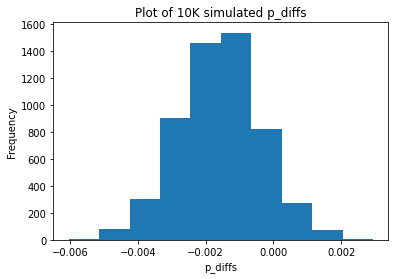

In [14]:
plt.hist(p_diffs)
plt.xlabel('p_diffs')
plt.ylabel('Frequency')
plt.title('Plot of 10K simulated p_diffs');



# A/B Testing: Calculate Z critical score and p_value (area) Over Dataset

In [15]:
import statsmodels.api as sm

convert_old = sum(df.query("group == 'control'")['converted'])
convert_new = sum(df.query("group == 'treatment'")['converted'])

z_score, p_value = sm.stats.proportions_ztest([convert_old, convert_new], [n_old, n_new], alternative='smaller')
print('z_critical_value: ', z_score)
print('p_critical_value: ', p_value)

z_critical_value:  1.3116075339133115
p_critical_value:  0.905173705140591


# A/B Testing: Calculate Z score corresponding to Alpha (0.05)

In [16]:
from scipy.stats import norm

print('p-value: ', norm.cdf(z_score))
# Tells us how significant our z-score is

# for our single-sides test, assumed at 95% confidence level, we calculate: 
print('z_alfa: ', norm.ppf(1 - (0.05)))

p-value:  0.905173705140591
z_alfa:  1.6448536269514722


# A/B Testing: Calculate Beta and Power corresponding to Alpha (0.05), Effect Size

In [17]:
# sm.stats.zt_ind_solve_power(effect_size=-0.0048, alpha=0.05, power=0.1, alternative='smaller')
from statsmodels.stats import power as pwr
from statsmodels.stats.proportion import proportion_effectsize

es = proportion_effectsize(p_new_page, p_old_page)
ratio = (n_new / n_old)
power = pwr.NormalIndPower().power(es, n_old / ratio, alpha=0.05, ratio=ratio, alternative='smaller')
beta = 1 - power

print('power: ', power)
print('beta: ', beta)

power:  0.3694135642365214
beta:  0.6305864357634786
